In [1]:
import random
import numpy as np
import pyxis as px
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image as Image
from scipy.misc import imresize

from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


## Load Datasets

* We will use pyxis LMDB datasetes to create our own python generator.

In [2]:
db_train = px.Reader('TRAIN')
db_val = px.Reader('VAL')

In [3]:
bt_size = 64
train_gen = px.StochasticBatch(db_train, keys=('image', 'mask','ncar'), batch_size=bt_size)
val_gen = px.StochasticBatch(db_val, keys=('image', 'mask','ncar'), batch_size=bt_size)

def generator(pxgen):
    while True:
        IMAGES,MASKS,NCAR= next(pxgen)
        for ind in range(IMAGES.shape[0]):
            if bool(random.getrandbits(1)):
                IMAGES[ind] = np.fliplr(IMAGES[ind])
                MASKS[ind] = np.fliplr(MASKS[ind])

        
        x = IMAGES
        y = MASKS
        y = y.reshape((y.shape[0],-1))
        y = y/255.0
        
        z = to_categorical(NCAR>0,2)
        yield x.astype(np.float32),y.astype(np.float32)
        
TRAIN=generator(train_gen)
VAL = generator(val_gen)
# x,y= next(TRAIN)
# x.shape, y.shape

## Visualize some samples

In [4]:
x,y= next(TRAIN)

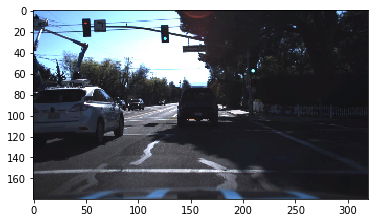

In [5]:
img = x[0].astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))

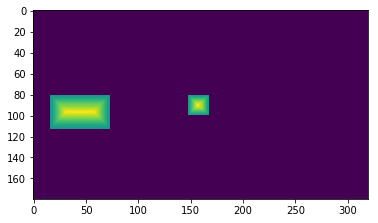

In [6]:
plt.imshow(y[0].reshape(x[0].shape[0:2]))

## Create Model and Train

Let create an Auto-enconder based CNN to map image to heatmap localization.

In [7]:
from keras.models import Model, Sequential
from keras.layers import *
from keras import backend as K
from keras.regularizers import l2,l1
from keras.backend import tf as ktf
from keras import optimizers
import keras
from skimage.feature import hog
from skimage import data, color, exposure
from keras.layers.advanced_activations import LeakyReLU, PReLU
inp = Input(shape=(None, None, 3))
try:
    x = Lambda(lambda image: ktf.image.resize_images(image, (180, 320)))(inp)
except :
    # if you have older version of tensorflow
    x = Lambda(lambda image: ktf.image.resize_images(image, 180, 320))(inp)



x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)


x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(32, (9, 16), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)


x = Conv2D(64, (9, 16), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)


x = Conv2DTranspose(32, (3, 7), padding="valid", activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(1, (17, 13), activation='sigmoid', padding='valid')(x)

x = Flatten()(x)
model = Model(inputs = inp, outputs = x)

model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 180, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 320, 32)      13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 320, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 160, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 160, 32)       147488    
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 160, 32)       128       
__________

### Train model

In [8]:
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.00001)]


model.fit_generator(TRAIN,
                    epochs=50,
                    max_queue_size=5,
                    workers=1,
                    steps_per_epoch=np.ceil(db_train.nb_samples/bt_size),
                    verbose=2,
                    callbacks=callbacks,
                    validation_data = VAL,
                    validation_steps= np.ceil(db_val.nb_samples/bt_size))
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/50
79s - loss: 0.2479 - val_loss: 4.4465
Epoch 2/50
70s - loss: 0.0590 - val_loss: 0.6612
Epoch 3/50
70s - loss: 0.0520 - val_loss: 0.0959
Epoch 4/50
70s - loss: 0.0444 - val_loss: 0.1197
Epoch 5/50
70s - loss: 0.0436 - val_loss: 0.0791
Epoch 6/50
70s - loss: 0.0414 - val_loss: 0.0782
Epoch 7/50
69s - loss: 0.0375 - val_loss: 0.0633
Epoch 8/50
69s - loss: 0.0360 - val_loss: 0.0637
Epoch 9/50
69s - loss: 0.0351 - val_loss: 0.0916
Epoch 10/50
69s - loss: 0.0349 - val_loss: 0.0645
Epoch 11/50
69s - loss: 0.0325 - val_loss: 0.0605
Epoch 12/50
70s - loss: 0.0308 - val_loss: 0.0813
Epoch 13/50
69s - loss: 0.0297 - val_loss: 0.0828
Epoch 14/50
70s - loss: 0.0287 - val_loss: 0.0822
Epoch 15/50

Epoch 00014: reducing learning rate to 0.00010000000474974513.
69s - loss: 0.0288 - val_loss: 0.0729
Epoch 16/50
69s - loss: 0.0268 - val_loss: 0.0439
Epoch 17/50
69s - loss: 0.0263 - val_loss: 0.0357
Epoch 18/50
70s - loss: 0.0250 - val_loss: 0.0371
Epoch 19/50
69s - loss: 0.0263 - val_loss: 0.

## Visualize Results

In [9]:
def pre_process(filename):
    img = np.array(Image.open(filename))
    cropped_img = imresize(img,(360,640), interp='bilinear')
    plt.imshow(cropped_img)
    return cropped_img

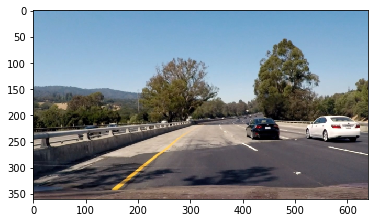

In [10]:
img = pre_process('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab);

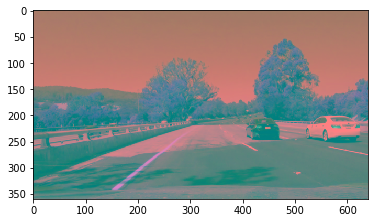

In [11]:
plt.imshow(img)

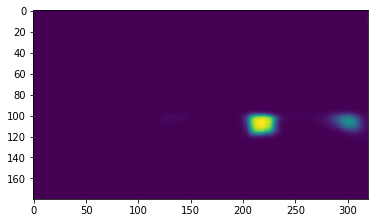

In [12]:
response = model.predict(img[np.newaxis,...])
response = response.reshape((180,320))
plt.imshow(response)

## Close pyxis DBs

In [13]:
db_train.close()
db_val.close()